# Neural Network Models

## Supervised Learning

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import nbimporter
import itertools
import TDFileParse as tdparse
import matplotlib.pyplot as plt
%matplotlib inline

Importing Jupyter notebook from TDFileParse.ipynb


In [2]:
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.datasets import load_iris
from sklearn.datasets import load_digits

from sklearn.preprocessing import scale

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import ParameterGrid

In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [4]:
## Read the input data files and display the data statistics

def returnData(scenario,datatype,labeltype,folder,validationData=True,validationRatio=0.2,dataLen=0):
    
    data = tdparse.getInputData(scenario, datatype, labeltype, folder,simtype = 'MultiClass',
                 validationData=validationData, validationRatio=validationRatio)
    data = dotdict(data)
    
    if not dataLen:
        return data
    
    else:
            
        data['trainingData'] = data.trainingData[:dataLen]
        data['trainingLabels'] = data.trainingLabels[:dataLen]
        data['testingData'] = data.testingData[:dataLen]
        data['testingLabels'] = data.testingLabels[:dataLen]
        
        if validationData:
            
            data['validationData'] = data.validationData[:dataLen]
            data['validationLabels'] = data.validationLabels[:dataLen]            
            
       
        return  data

def getXdata(datakind,validationData = True):
    data = {}
    
    assert(datakind in ['iris','digits','Unrecognized dataset'])
    
    if datakind is 'iris':
        temp = load_iris()
        
        data['trainingData'], data['testingData'], data['trainingLabels'], data['testingLabels'] = (
        train_test_split(temp.data, temp.target, test_size=0.2)
        )
        
        data['labels'] = np.unique(temp.target)
        
        if validationData is True:
            data['trainingData'], data['validationData'], data['trainingLabels'], data['validationLabels'] = (
        train_test_split(data['trainingData'], data['trainingLabels'], test_size=0.2)
            )
            
            
        
    elif datakind is 'digits':
        temp = load_digits()
        
        data['trainingData'], data['testingData'], data['trainingLabels'], data['testingLabels'] = ( 
        train_test_split(temp.data, temp.target, test_size=0.2)
        )
        
        data['labels'] = temp.target_names
        
        if validationData is True:
            data['trainingData'], data['validationData'], data['trainingLabels'], data['validationLabels'] = ( 
        train_test_split(data['trainingData'], data['trainingLabels'], test_size=0.2)
            )
        
    
    data = dotdict(data)
        
        
    return data
        
        
        

def getClusterMeans(X,y,nLabels,plot=True, colors=None):
    
    if colors is None:
        colors = sns.cubehelix_palette(n_colors=nLabels+1, start = 1)
    
    numDims = np.shape(X)[1] 
    
    clusterMeans = np.array(np.ones((nLabels,numDims), dtype=np.float64))   
       

    for i in range(nLabels):
        clusterMeans[i,:] = X[np.where(y==i)[0]].mean(axis=0)        
        
    if plot is True:
        fig = plt.figure(figsize=(15,6))
        for i in range(nLabels):
            subplot = fig.add_subplot(2,2,i+1)
            plt.plot(list(range(1,numDims+1)),clusterMeans[i,:], c=colors[i+1])
            plt.title('Label ' + str(i))
            plt.ylim([np.min(X),np.max(X)])
            
        fig.tight_layout()
        
    return clusterMeans

### Data Preprocessing

def PreProcessData(inputData, shuffling = True):
    
    # Shuffle the data
    if shuffling:
        inputData['trainingData'], inputData['trainingLabels'] = (
            shuffle(inputData['trainingData'], inputData['trainingLabels'])
        )
        
        inputData['testingData'], inputData['testingLabels'] = (
            shuffle(inputData['testingData'], inputData['testingLabels'])
        )
        
        if inputData['validationData'].any():
            inputData['validationData'], inputData['validationLabels'] = (
                shuffle(inputData['validationData'], inputData['validationLabels'])
            )
    
    ## Create a scaling object and scale the data
    
    
    inputData['trainingData'] = scale(inputData['trainingData'],with_mean = True, with_std = True )
    
    inputData['testingData'] = scale(inputData['testingData'],with_mean = True, with_std = True )
    
    if inputData['validationData'].any():
        inputData['validationData'] = scale(inputData['validationData'],with_mean = True, with_std = True )   
    
  
  
    return inputData

In [5]:
## Importing Data
folder = 'paperData'
scenario = 'indoor'           #['outdoor','indoor']
datatype = 'motionfiltered'    #['raw','baseband','motionfiltered']
labeltype = 'simple_multi'     #[simple_multi]
samples = 100 
validationData = True
validationRatio=0.2

datakind = 'OD'              #['OD','iris','digits']


if datakind is not 'OD':
    inputData = getXdata(datakind, validationData)
    
else:
    inputData = returnData(scenario,datatype,labeltype,folder,validationData=validationData,
                           validationRatio=validationRatio,dataLen=0)


MultiClass : Parsing X from paperData
Scenario: indoor
Labeling: simple_multi
Datatype: motionfiltered
-------------------------------------------------------------------------------------
The Shape of training data is (5583, 480)
The Shape of testing data is (2692, 480)
-------------------------------------------------------------------------------------
The bincount for training labels is Counter({0: 2350, 1: 1340, 3: 950, 2: 943})
The bincount for testing labels is Counter({3: 801, 0: 785, 2: 694, 1: 412})
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------


## Preprocess Data

In [6]:
PreProcessData(inputData);

In [7]:
inputData.trainingData.shape

(4466, 480)

## Multi-layer Perceptron

In [8]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()

params = {'hidden_layer_sizes' : [(100,),(200,),(300,),(400,)],
          'activation' : ['identity', 'logistic', 'tanh', 'relu'],
          'solver' : ['lbfgs', 'sgd', 'adam'],
          'alpha' : [0.0001, 0.0005, 0.001, 0.005],
          'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    
}

gs = GridSearchCV(model, params, cv=3, n_jobs=-1, scoring='accuracy', verbose=10)
gs.fit(inputData.trainingData, inputData.trainingLabels.ravel())

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed: 10.0min
[Paralle

GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(100,), (200,), (300,), (400,)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'alpha': [0.0001, 0.0005, 0.001, 0.005], 'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate': ['constant', 'invscaling', 'adaptive']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=10)

In [9]:
gs.cv_results_.keys()

dict_keys(['param_activation', 'mean_test_score', 'split1_train_score', 'param_solver', 'std_fit_time', 'split0_train_score', 'mean_fit_time', 'param_alpha', 'split2_train_score', 'split0_test_score', 'std_train_score', 'std_test_score', 'params', 'mean_score_time', 'param_learning_rate', 'mean_train_score', 'split1_test_score', 'split2_test_score', 'param_hidden_layer_sizes', 'rank_test_score', 'std_score_time'])

In [11]:
gs.cv_results_['params'][0].keys()

dict_keys(['activation', 'hidden_layer_sizes', 'learning_rate', 'alpha', 'solver'])

In [12]:
paramsList = gs.cv_results_['params'][0].keys()
header = list(paramsList)

header.extend(['trainingScore', 'validationScore'])
header

['activation',
 'hidden_layer_sizes',
 'learning_rate',
 'alpha',
 'solver',
 'trainingScore',
 'validationScore']

In [13]:
df = pd.DataFrame(columns=header)
bigList = []

for idx, each in enumerate(gs.cv_results_['params']):
    temp = list(each.values())
    temp.extend([gs.cv_results_['mean_train_score'][idx], gs.cv_results_['mean_test_score'][idx]])
    
    bigList.append(temp)

C:\Users\User\Anaconda3\envs\python_sdc\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [14]:
import os
bigDf = pd.DataFrame(bigList, columns=header)

fileName = os.path.join('unsupervisedEval', 'dataframes', 'MLP.pkl')

bigDf.to_pickle(fileName)

## Unsupervised NN

In [8]:
from sklearn.neural_network import BernoulliRBM

In [9]:
learningRates = [0.001, 0.005, 0.01, 0.05, 0.1]

In [11]:
trainingAccuracynnU, validationAccuracynnU = [], []

for each in learningRates:
    
    print('Using Learning rate',each)
    nnUnsupervised = BernoulliRBM(n_components=4, learning_rate=each)
    
    trainingFit = nnUnsupervised.fit_transform(inputData.trainingData)
    validationFit = nnUnsupervised.fit_transform(inputData.validationData)
    
    estimator = RandomForestClassifier(n_estimators=4,n_jobs=-1)
    estimator.fit(trainingFit, inputData.trainingLabels.ravel())
    
    predictedTraining = estimator.predict(trainingFit)
    predictedValidation = estimator.predict(validationFit)
    
    accuracyTraining = accuracy_score(inputData.trainingLabels.ravel(),predictedTraining)
    print('Training Accuracy:', accuracyTraining)
    
    accuracyValidation = accuracy_score(inputData.validationLabels.ravel(), predictedValidation)
    print('Validation Accuracy:', accuracyValidation)
    
    
    trainingAccuracynnU.append(accuracyTraining)
    validationAccuracynnU.append(accuracyValidation)
    
    print('-----------------------------------------')
    
    
    

Using Learning rate 0.001
Training Accuracy: 0.719883564711
Validation Accuracy: 0.353625783348
-----------------------------------------
Using Learning rate 0.005
Training Accuracy: 0.530452306314
Validation Accuracy: 0.346463742167
-----------------------------------------
Using Learning rate 0.01
Training Accuracy: 0.489699955217
Validation Accuracy: 0.457475380483
-----------------------------------------
Using Learning rate 0.05
Training Accuracy: 0.47671294223
Validation Accuracy: 0.259623992838
-----------------------------------------
Using Learning rate 0.1
Training Accuracy: 0.449619346171
Validation Accuracy: 0.254252461952
-----------------------------------------


In [26]:
test = pd.DataFrame(data=[trainingAccuracynnU,validationAccuracynnU])
test = test.transpose()
test.columns = ['trainingScore', 'validationScore']
test['Estimator'] = 'RBM'
test

trainingScore  validationScore Estimator
0       0.719884         0.353626       RBM
1       0.530452         0.346464       RBM
2       0.489700         0.457475       RBM
3       0.476713         0.259624       RBM
4       0.449619         0.254252       RBM

0         1
0  0.719884  0.353626
1  0.530452  0.346464
2  0.489700  0.457475
3  0.476713  0.259624
4  0.449619  0.254252

In [18]:
trainingAccuracynnU = np.array(trainingAccuracynnU)

validationAccuracynnU = np.array(validationAccuracynnU)

idx = np.argmax(validationAccuracynnU)


In [19]:
print('Refitting Using Learning rate',learningRates[idx])
nnUnsupervised = BernoulliRBM(n_components=4, learning_rate=learningRates[idx])

trainingFit = nnUnsupervised.fit_transform(inputData.trainingData)
validationFit = nnUnsupervised.fit_transform(inputData.validationData)
testingFit = nnUnsupervised.fit_transform(inputData.testingData)

estimator = RandomForestClassifier(n_estimators=4,n_jobs=-1)
estimator.fit(trainingFit, inputData.trainingLabels)

predictedTraining = estimator.predict(trainingFit)
predictedValidation = estimator.predict(validationFit)
predictedTest = estimator.predict(testingFit)

accuracyTraining = accuracy_score(inputData.trainingLabels.ravel(),predictedTraining)
print('Training Accuracy:', accuracyTraining)

accuracyValidation = accuracy_score(inputData.validationLabels.ravel(), predictedValidation)
print('Validation Accuracy:', accuracyValidation)

accuracyTesting = accuracy_score(inputData.testingLabels.ravel(), predictedTest)
print('Test Accuracy:', accuracyTesting)

print('-----------------------------------------')
    

Refitting Using Learning rate 0.1


C:\Users\User\Anaconda3\envs\python_sdc\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Training Accuracy: 0.474921630094
Validation Accuracy: 0.479856759176
Test Accuracy: 0.312035661218
-----------------------------------------


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
fileName = 'unsupervisedEval/dataframes/MLP.pkl'

In [29]:
nns = pd.read_pickle(fileName)

In [35]:
accuracy_score(inputData.trainingLabels.ravel(), validation)

0.66000000000000003

In [30]:
nns['Estimator'] = 'MLP'
nns

activation hidden_layer_sizes learning_rate   alpha solver  trainingScore  \
0     identity             (100,)      constant  0.0001  lbfgs       0.490375   
1     identity             (100,)      constant  0.0001    sgd       0.476939   
2     identity             (100,)      constant  0.0001   adam       0.482319   
3     identity             (100,)    invscaling  0.0001  lbfgs       0.493957   
4     identity             (100,)    invscaling  0.0001    sgd       0.257270   
5     identity             (100,)    invscaling  0.0001   adam       0.493397   
6     identity             (100,)      adaptive  0.0001  lbfgs       0.492166   
7     identity             (100,)      adaptive  0.0001    sgd       0.477387   
8     identity             (100,)      adaptive  0.0001   adam       0.475713   
9     identity             (200,)      constant  0.0001  lbfgs       0.492053   
10    identity             (200,)      constant  0.0001    sgd       0.480857   
11    identity             (200,)      constant  0.0001   adam       0.481644   
12    identity             (200,)    invscaling  0.0001  lbfgs       0.489142   
13    identity             (200,)    invscaling  0.0001    sgd       0.251460   
14    identity             (200,)    invscaling  0.0001   adam       0.480520   
15    identity             (200,)      adaptive  0.0001  lbfgs       0.489590   
16    identity             (200,)      adaptive  0.0001    sgd       0.476603   
17    identity             (200,)      adaptive  0.0001   adam       0.471227   
18    identity             (300,)      constant  0.0001  lbfgs       0.489815   
19    identity             (300,)      constant  0.0001    sgd       0.479290   
20    identity             (300,)      constant  0.0001   adam       0.488808   
21    identity             (300,)    invscaling  0.0001  lbfgs       0.490374   
22    identity             (300,)    invscaling  0.0001    sgd       0.295791   
23    identity             (300,)    invscaling  0.0001   adam       0.484215   
24    identity             (300,)      adaptive  0.0001  lbfgs       0.490150   
25    identity             (300,)      adaptive  0.0001    sgd       0.480411   
26    identity             (300,)      adaptive  0.0001   adam       0.481426   
27    identity             (400,)      constant  0.0001  lbfgs       0.487911   
28    identity             (400,)      constant  0.0001    sgd       0.482762   
29    identity             (400,)      constant  0.0001   adam       0.486682   
..         ...                ...           ...     ...    ...            ...   
546       relu             (100,)      adaptive  0.0050  lbfgs       1.000000   
547       relu             (100,)      adaptive  0.0050    sgd       0.907301   
548       relu             (100,)      adaptive  0.0050   adam       1.000000   
549       relu             (200,)      constant  0.0050  lbfgs       1.000000   
550       relu             (200,)      constant  0.0050    sgd       0.922975   
551       relu             (200,)      constant  0.0050   adam       1.000000   
552       relu             (200,)    invscaling  0.0050  lbfgs       1.000000   
553       relu             (200,)    invscaling  0.0050    sgd       0.316962   
554       relu             (200,)    invscaling  0.0050   adam       1.000000   
555       relu             (200,)      adaptive  0.0050  lbfgs       1.000000   
556       relu             (200,)      adaptive  0.0050    sgd       0.922638   
557       relu             (200,)      adaptive  0.0050   adam       1.000000   
558       relu             (300,)      constant  0.0050  lbfgs       1.000000   
559       relu             (300,)      constant  0.0050    sgd       0.936521   
560       relu             (300,)      constant  0.0050   adam       1.000000   
561       relu             (300,)    invscaling  0.0050  lbfgs       1.000000   
562       relu             (300,)    invscaling  0.0050    sgd       0.342701   
563       relu             (300,)  

In [32]:
 finaldf = pd.concat([test, nns], ignore_index=True)

In [35]:
finaldf

Estimator activation   alpha hidden_layer_sizes learning_rate solver  \
0         RBM        NaN     NaN                NaN           NaN    NaN   
1         RBM        NaN     NaN                NaN           NaN    NaN   
2         RBM        NaN     NaN                NaN           NaN    NaN   
3         RBM        NaN     NaN                NaN           NaN    NaN   
4         RBM        NaN     NaN                NaN           NaN    NaN   
5         MLP   identity  0.0001             (100,)      constant  lbfgs   
6         MLP   identity  0.0001             (100,)      constant    sgd   
7         MLP   identity  0.0001             (100,)      constant   adam   
8         MLP   identity  0.0001             (100,)    invscaling  lbfgs   
9         MLP   identity  0.0001             (100,)    invscaling    sgd   
10        MLP   identity  0.0001             (100,)    invscaling   adam   
11        MLP   identity  0.0001             (100,)      adaptive  lbfgs   
12        MLP   identity  0.0001             (100,)      adaptive    sgd   
13        MLP   identity  0.0001             (100,)      adaptive   adam   
14        MLP   identity  0.0001             (200,)      constant  lbfgs   
15        MLP   identity  0.0001             (200,)      constant    sgd   
16        MLP   identity  0.0001             (200,)      constant   adam   
17        MLP   identity  0.0001             (200,)    invscaling  lbfgs   
18        MLP   identity  0.0001             (200,)    invscaling    sgd   
19        MLP   identity  0.0001             (200,)    invscaling   adam   
20        MLP   identity  0.0001             (200,)      adaptive  lbfgs   
21        MLP   identity  0.0001             (200,)      adaptive    sgd   
22        MLP   identity  0.0001             (200,)      adaptive   adam   
23        MLP   identity  0.0001             (300,)      constant  lbfgs   
24        MLP   identity  0.0001             (300,)      constant    sgd   
25        MLP   identity  0.0001             (300,)      constant   adam   
26        MLP   identity  0.0001             (300,)    invscaling  lbfgs   
27        MLP   identity  0.0001             (300,)    invscaling    sgd   
28        MLP   identity  0.0001             (300,)    invscaling   adam   
29        MLP   identity  0.0001             (300,)      adaptive  lbfgs   
..        ...        ...     ...                ...           ...    ...   
551       MLP       relu  0.0050             (100,)      adaptive  lbfgs   
552       MLP       relu  0.0050             (100,)      adaptive    sgd   
553       MLP       relu  0.0050             (100,)      adaptive   adam   
554       MLP       relu  0.0050             (200,)      constant  lbfgs   
555       MLP       relu  0.0050             (200,)      constant    sgd   
556       MLP       relu  0.0050             (200,)      constant   adam   
557       MLP       relu  0.0050             (200,)    invscaling  lbfgs   
558       MLP       relu  0.0050             (200,)    invscaling    sgd   
559       MLP       relu  0.0050             (200,)    invscaling   adam   
560       MLP       relu  0.0050             (200,)      adaptive  lbfgs   
561       MLP       relu  0.0050             (200,)      adaptive    sgd   
562       MLP       relu  0.0050             (200,)      adaptive   adam   
563       MLP       relu  0.0050             (300,)      constant  lbfgs   
564       MLP       relu  0.0050             (300,)      constant    sgd   
565       MLP       relu  0.0050             (300,)      constant   adam   
566       MLP       relu  0.0050             (300,)    invscaling  lbfgs   
567       MLP       relu  0.0050             (300,)    invscaling    sgd   
568       MLP       relu  0.0050             (300,)    invscaling   adam   
569       MLP       relu  0.0050             (300,)      adaptive  lbfgs   
570       MLP       relu  0.0050             (300,)      adaptive    sgd   
571       MLP       relu  0.0050             (300,) 

In [34]:
melteddf = pd.melt(finaldf, id_vars=['Estimator'], value_vars=['trainingScore', 'validationScore'], 
                  var_name='Scoring', value_name='Accuracy')
melteddf

Estimator          Scoring  Accuracy
0          RBM    trainingScore  0.719884
1          RBM    trainingScore  0.530452
2          RBM    trainingScore  0.489700
3          RBM    trainingScore  0.476713
4          RBM    trainingScore  0.449619
5          MLP    trainingScore  0.490375
6          MLP    trainingScore  0.476939
7          MLP    trainingScore  0.482319
8          MLP    trainingScore  0.493957
9          MLP    trainingScore  0.257270
10         MLP    trainingScore  0.493397
11         MLP    trainingScore  0.492166
12         MLP    trainingScore  0.477387
13         MLP    trainingScore  0.475713
14         MLP    trainingScore  0.492053
15         MLP    trainingScore  0.480857
16         MLP    trainingScore  0.481644
17         MLP    trainingScore  0.489142
18         MLP    trainingScore  0.251460
19         MLP    trainingScore  0.480520
20         MLP    trainingScore  0.489590
21         MLP    trainingScore  0.476603
22         MLP    trainingScore  0.471227
23         MLP    trainingScore  0.489815
24         MLP    trainingScore  0.479290
25         MLP    trainingScore  0.488808
26         MLP    trainingScore  0.490374
27         MLP    trainingScore  0.295791
28         MLP    trainingScore  0.484215
29         MLP    trainingScore  0.490150
...        ...              ...       ...
1132       MLP  validationScore  0.727497
1133       MLP  validationScore  0.736901
1134       MLP  validationScore  0.766906
1135       MLP  validationScore  0.743842
1136       MLP  validationScore  0.744514
1137       MLP  validationScore  0.767801
1138       MLP  validationScore  0.738916
1139       MLP  validationScore  0.308777
1140       MLP  validationScore  0.773399
1141       MLP  validationScore  0.736901
1142       MLP  validationScore  0.742499
1143       MLP  validationScore  0.774519
1144       MLP  validationScore  0.739588
1145       MLP  validationScore  0.743171
1146       MLP  validationScore  0.781236
1147       MLP  validationScore  0.736229
1148       MLP  validationScore  0.333856
1149       MLP  validationScore  0.772951
1150       MLP  validationScore  0.744066
1151       MLP  validationScore  0.747425
1152       MLP  validationScore  0.775414
1153       MLP  validationScore  0.743395
1154       MLP  validationScore  0.744066
1155       MLP  validationScore  0.782579
1156       MLP  validationScore  0.741379
1157       MLP  validationScore  0.351993
1158       MLP  validationScore  0.774295
1159       MLP  validationScore  0.745410
1160       MLP  validationScore  0.753023
1161       MLP  validationScore  0.781684

[1162 rows x 3 columns]

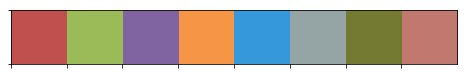

In [38]:
current_palette = sns.color_palette(["#C0504D","#9BBA58","#8063A1","#F79546","#3498db", "#95a5a6",  "#747A32", "#C1796F"])

sns.palplot(current_palette)

In [39]:
sns.set(font_scale=1.5)

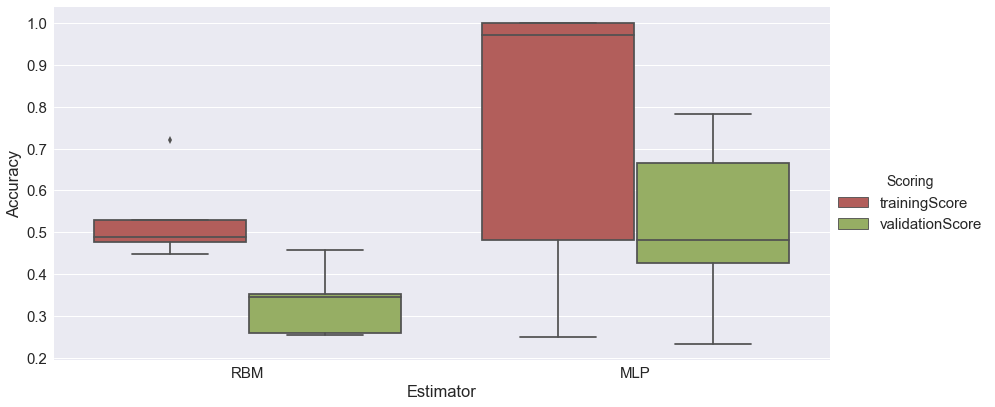

In [41]:
sns.factorplot(x='Estimator', y='Accuracy', hue='Scoring', data=melteddf, kind='box', palette=current_palette,
              aspect=2, size=6)

In [42]:
nns.validationScore.argmax()

503

## MLP final 

In [46]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()

In [51]:
finalParams = dict(nns.iloc[503,:])

In [48]:
finalParams

{'Estimator': 'MLP',
 'activation': 'relu',
 'alpha': 0.00050000000000000001,
 'hidden_layer_sizes': (400,),
 'learning_rate': 'adaptive',
 'solver': 'adam',
 'trainingScore': 1.0,
 'validationScore': 0.78347514554411102}

In [52]:
del finalParams['trainingScore']
del finalParams['validationScore']
del finalParams['Estimator']

In [53]:
model.set_params(**finalParams)
model

MLPClassifier(activation='relu', alpha=0.00050000000000000001,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [54]:
model.fit(inputData.trainingData, inputData.trainingLabels.ravel())

predictedTraining = model.predict(inputData.trainingData)
predictedValidation = model.predict(inputData.validationData)
predictedTest = model.predict(inputData.testingData)

print('Training Accuracy:', accuracy_score(inputData.trainingLabels.ravel(), predictedTraining))

print('Validation Accuracy:', accuracy_score(inputData.validationLabels.ravel(), predictedValidation))

print('Testing Accuracy:', accuracy_score(inputData.testingLabels.ravel(), predictedTest))


Training Accuracy: 1.0
Validation Accuracy: 0.806624888093
Testing Accuracy: 0.640416047548
